# CSE 3000: Content Moderation (Toxic Comments and Bias Anaylsis)

Goal: Toxic text classification

Definition
- "toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion."

### Imports and Files

In [2]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from google.colab import files # uncomment to run in Google Colab

Upload (Google Colab):

1.   `tokenized_train.csv` (LARGE, can take around 6 mins)
2.   `test_data_predictions.csv`




NOTE: Can skip preprocessed csv if taking too long to download, but will have to skip logistic regression, naive bayes sections. This took around 6 minutes when I tried.

In [ ]:
# uploaded_files = files.upload() # uncomment to upload files in google colab

Saving test_data_predictions.csv to test_data_predictions.csv


## Trimming Dataset

We will not be executing this code, but this is just to show how the dataset was trimmed before official preprocessing.

In [ ]:
'''
# Load the CSV file into a DataFrame
df = pd.read_csv('full_train.csv')

# Remove rows where 'other_race_or_ethnicity' is NULL (NaN)
# Doesnt matter which label is used for this purpose, as they have all or none
df = df.dropna(subset=['other_race_or_ethnicity'])

# Remove rows where 'toxicity_annotator_count' is less than 10
df = df[df['toxicity_annotator_count'] >= 10]

# Save the cleaned DataFrame to a new CSV file (optional)
df.to_csv('cleaned_file.csv', index=False)
'''

## Preprocessing for baseline models

Simple models require tokenizing the text so that words are individual features. This is not required for more complex models such as BERT which we will explore as well. Below is the general process we used to process the text, although to simplify things we will feed our baseline models the already-preprocessed dataset.

In [ ]:
'''
import re
import emoji
from contractions import fix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    # Normalize special characters (e.g., "bit__" → "bit_")
    text = re.sub(r'([!@#$%^&*()_+=\-[\]{};:\'",./<>?|\\~`])\1*', r'\1', text)
    # Convert emojis to text
    text = emoji.demojize(text)
    # Expand contractions
    text = fix(text)
    # Normalize slang
    text = re.sub(r'\bu\b', 'you', text)
    # Remove URLs, mentions, and hashtags
    text = re.sub(r'http\S+|@\w+|#\w+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Function to tokenize text (without tokenizing punctuation)
def tokenize_text(text):
    # Use regex to split into words while preserving special characters within words
    tokens = re.findall(r'\b\w+\b', text)
    # Remove stop words (optional)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return tokens
'''

'\nimport nltk\nnltk.download(\'punkt\')\nnltk.download(\'stopwords\')\n\ndef preprocess_text(text):\n    # Normalize special characters (e.g., "bit__" → "bit_")\n    text = re.sub(r\'([!@#$%^&*()_+=\\-[\\]{};:\'",./<>?|\\~`])\x01*\', r\'\x01\', text)\n    # Convert emojis to text\n    text = emoji.demojize(text)\n    # Expand contractions\n    text = fix(text)\n    # Normalize slang\n    text = re.sub(r\'\x08u\x08\', \'you\', text)\n    # Remove URLs, mentions, and hashtags\n    text = re.sub(r\'http\\S+|@\\w+|#\\w+\', \'\', text)\n    # Convert to lowercase\n    text = text.lower()\n    # Remove extra whitespace\n    text = \' \'.join(text.split())\n    return text\n\n# Function to tokenize text (without tokenizing punctuation)\ndef tokenize_text(text):\n    # Use regex to split into words while preserving special characters within words\n    tokens = re.findall(r\'\x08\\w+\x08\', text)\n    # Remove stop words (optional)\n    stop_words = set(stopwords.words(\'english\'))\n    token

## Dataset Info

In [4]:
df = pd.read_csv('csv_data/tokenized_train.csv')
df.head()
df['binary_target'] = (df['target'] >= 0.5).astype(int)
print(f"Dataset shape: {df.shape}")
print(f"Number of toxic comments (target >= 0.5): {df['binary_target'].sum()}")
print(f"Number of non-toxic comments (target < 0.5): {len(df) - df['binary_target'].sum()}")

Dataset shape: (107910, 48)
Number of toxic comments (target >= 0.5): 44031
Number of non-toxic comments (target < 0.5): 63879


## Logistic Regression Model

Perform logistic regression to classify text. Takes preprocessed data.

In [5]:
df = pd.read_csv('csv_data/tokenized_train.csv')

# Ensure the 'tokens' column is a list of strings
df['tokens'] = df['tokens'].apply(eval)  # Convert string representation of list to actual list

# Join tokens into a single string
df['text'] = df['tokens'].apply(lambda x: ' '.join(x))

tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # You can adjust max_features
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

In [6]:
X = tfidf_matrix  # Features (TF-IDF matrix)
df['binary_target'] = (df['target'] >= 0.5).astype(int)
y = df['binary_target']   # Target labels (toxic/non-toxic)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [8]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7256973403762395
Report:
               precision    recall  f1-score   support

           0       0.72      0.87      0.79     12706
           1       0.73      0.52      0.61      8876

    accuracy                           0.73     21582
   macro avg       0.73      0.70      0.70     21582
weighted avg       0.73      0.73      0.72     21582



## Naive Bayes

We will quickly try two models for Naive Bayes: Multinomial Naive Bayes and Complement Naive Bayes.

Complement Naive Bayes is theoretically better at handling imbalance. We have some imbalance although not extreme so may not see significant improvement.

In [9]:
# Train a Multinomial NB model
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [10]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6877953850430915
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.91      0.77     12706
           1       0.74      0.37      0.49      8876

    accuracy                           0.69     21582
   macro avg       0.71      0.64      0.63     21582
weighted avg       0.70      0.69      0.66     21582



In [11]:
# Train a Complement NB model
model = ComplementNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [12]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6587897321842276
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.65      0.69     12706
           1       0.57      0.67      0.62      8876

    accuracy                           0.66     21582
   macro avg       0.66      0.66      0.65     21582
weighted avg       0.67      0.66      0.66     21582



Clearly, Logistic Regression performs the best out of these baseline models. As predicted, Complement NB performs better (more consistent across classes) than Multinomial NB by handling the imbalance. We will go more in depth in the next section with a transformer approach.

# BERT Binary Classification Model

Uses BERT model, too computationally expensive to run on Google Colab, so we will just import the full predictions csv.

## Load Data

In [14]:
full_predictions = pd.read_csv('csv_data/test_data_predictions.csv')
full_predictions.head()

,comment_text,human_binary,predicted_binary,human_decimal,predicted_decimal,asian,atheist,bisexual,black,buddhist,...,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white
0,"""But, but, but, what about the things Trump do...",0,0,0.2,0.280961,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0
1,Speaking for women and saying you aren't sexis...,0,0,0.2,0.099996,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,I thought Liberal Trolls had Wednesday off!,0,1,0.2,0.741768,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,Nonsense. I said no such thing. If you poke a ...,0,0,0.2,0.166269,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,Maybe he was a degenerate descendant of Vlad t...,0,0,0.4,0.276935,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [15]:
human_labels = full_predictions['human_binary']
predicted_labels = full_predictions['predicted_binary']

## Overall Results

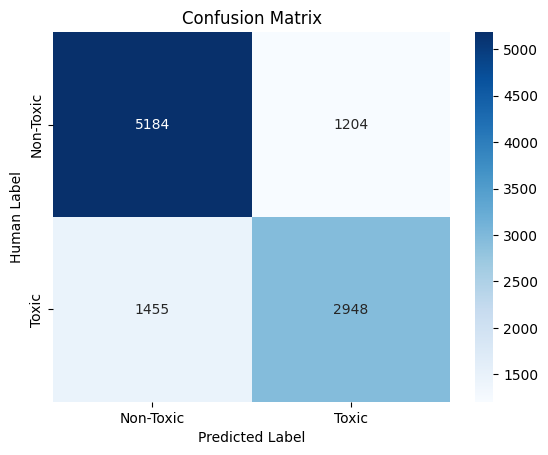

In [16]:
axis_labels = ['Non-Toxic', 'Toxic']

sns.heatmap(confusion_matrix(human_labels, predicted_labels),
            annot=True,     # Show numbers in the cells
            fmt='d',        # Format numbers as integers
            cmap='Blues',   # Color scheme
            xticklabels=axis_labels,
            yticklabels=axis_labels)

plt.xlabel('Predicted Label')
plt.ylabel('Human Label')
plt.title('Confusion Matrix')
plt.show()

### Classification Report (Precision, Recall, F1)

In [17]:
print(classification_report(human_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80      6388
           1       0.71      0.67      0.69      4403

    accuracy                           0.75     10791
   macro avg       0.75      0.74      0.74     10791
weighted avg       0.75      0.75      0.75     10791



In [18]:
print(accuracy_score(human_labels, predicted_labels))

0.7535909554258178


### ROC-AUC

ROC Curve tells us how the model performs in comparison to random chance across all possible classification thresholds. AUC is simply area-under-curve so given that it is a 1x1 grid, the closer to 1 the better.

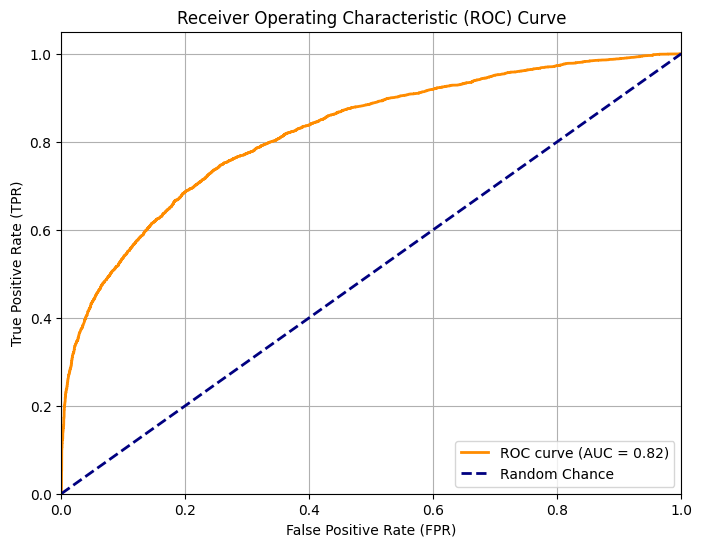

In [19]:
fpr, tpr, thresholds = roc_curve(human_labels, full_predictions['predicted_decimal'])

# --- Calculate AUC score ---
auc = roc_auc_score(human_labels, full_predictions['predicted_decimal'])

# --- Plot the ROC curve ---
plt.figure(figsize=(8, 6))

# Plot the ROC curve (FPR vs TPR)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')

# Plot the diagonal line representing random chance
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05]) # Slightly > 1 to ensure curve is fully visible
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right") # Show legend
plt.grid(True)
plt.show()

## Random Sampling

Explore random samples
- this can be used to find specific examples for presentation or report if needed (where model is right and human is wrong and vice versa)
- useful to compare decimal prediction as well

In [20]:
pd.set_option('display.max_colwidth', None) # Show full content of columns

In [21]:
full_predictions.sample(n=1).iloc[:,0:5]

,comment_text,human_binary,predicted_binary,human_decimal,predicted_decimal
4261,"If it takes making America the dumbest country on the planet to keep the Republican party afloat, so be it, say Republicans.",1,1,0.690141,0.97532


## Bias Analysis

View how many samples have the listed identities greater than 0.0.

In [22]:
print(f"Identity                               Count Toxic  Non-toxic")
for identity in full_predictions.columns[5:-1]:

    # 1. Create a boolean mask for rows where the identity > 0.0
    is_positive_mask = full_predictions[identity] > 0.0

    # 2. Get the total count of positive samples for this identity
    total_positive_count = is_positive_mask.sum()

    # Initialize counts for labels 1 and 0
    count_label_1 = 0
    count_label_0 = 0

    # 3. If there are any rows meeting the condition (> 0.0)...
    if total_positive_count > 0:
        # Select the 'true_label' column *only* for the rows identified by the mask
        labels_for_positive_rows = full_predictions.loc[is_positive_mask, 'human_binary']

        # Count the occurrences of 1 and 0 within this subset of labels
        count_label_1 = (labels_for_positive_rows == 1).sum()
        count_label_0 = (labels_for_positive_rows == 0).sum()

    # 4. Print the results for this identity feature
    print(f"{identity:36s}: {total_positive_count:5d} {count_label_1:5d} {count_label_0:5d}")

Identity                               Count Toxic  Non-toxic
asian                               :   293   113   180
atheist                             :    65    22    43
bisexual                            :   130    52    78
black                               :  1114   541   573
buddhist                            :    37    15    22
christian                           :  1600   513  1087
female                              :  2441   988  1453
heterosexual                        :   163    64    99
hindu                               :    47    12    35
homosexual_gay_or_lesbian           :   835   375   460
intellectual_or_learning_disability :   112    65    47
jewish                              :   408   149   259
latino                              :   237   118   119
male                                :  2685  1130  1555
muslim                              :  1285   527   758
other_disability                    :   108    42    66
other_gender                        :    9

### False positive/negative rates
- this should help determine which identities are most often misclassified
- comes with a grain of salt because humans are labeling these identities and it is not their main objective

In [23]:
false_preds = dict()
print("FP,     FN,    Identity")
for identity in full_predictions.columns[5:-1]:
  selected_preds = full_predictions[(full_predictions[identity] > 0.0)]
  tn, fp, fn, tp = confusion_matrix(selected_preds['human_binary'],selected_preds['predicted_binary']).ravel()
  false_preds[identity] = [fp/(fp+tn), fn/(fn+tp)]
for key, value in false_preds.items():
  print(f"{round(value[0], 4):.4f}, {round(value[1], 4):.4f} {key}")

FP,     FN,    Identity
0.2056, 0.3805 asian
0.2791, 0.4091 atheist
0.1667, 0.3462 bisexual
0.2723, 0.2791 black
0.0909, 0.5333 buddhist
0.1490, 0.4074 christian
0.2017, 0.3330 female
0.2121, 0.4062 heterosexual
0.1429, 0.2500 hindu
0.2109, 0.3493 homosexual_gay_or_lesbian
0.3191, 0.1692 intellectual_or_learning_disability
0.1660, 0.5235 jewish
0.1933, 0.2797 latino
0.2109, 0.3142 male
0.2150, 0.3757 muslim
0.2273, 0.4524 other_disability
0.1961, 0.3590 other_gender
0.2000, 0.3398 other_race_or_ethnicity
0.1777, 0.3226 other_religion
0.1525, 0.4091 other_sexual_orientation
0.0909, 0.4878 physical_disability
0.1889, 0.2596 psychiatric_or_mental_illness
0.1412, 0.4200 transgender


### AUC scores by identity

- focus on underperformance relative to overall average

In [24]:
auc_identities = dict()
print("AUC     Identity")
for identity in full_predictions.columns[5:-1]:
  selected_preds = full_predictions[(full_predictions[identity] > 0.0)]
  auc = roc_auc_score(selected_preds['human_binary'],selected_preds['predicted_decimal'])
  auc_identities[identity] = auc
auc_identities = {k: v for k, v in sorted(auc_identities.items(), key=lambda item: item[1], reverse=True)}
for key, value in auc_identities.items():
  print(f"{round(value, 4):.4f}, {key}")

AUC     Identity
0.9048, hindu
0.8481, other_religion
0.8450, psychiatric_or_mental_illness
0.8412, intellectual_or_learning_disability
0.8407, bisexual
0.8361, transgender
0.8353, latino
0.8335, other_sexual_orientation
0.8160, other_gender
0.8154, christian
0.8152, buddhist
0.8149, female
0.8093, heterosexual
0.8080, male
0.8073, asian
0.8025, other_race_or_ethnicity
0.8021, homosexual_gay_or_lesbian
0.8011, black
0.7828, jewish
0.7779, muslim
0.7722, other_disability
0.7596, physical_disability
0.7262, atheist


Noteworthy contrast could be between disability types... strong at mental disability, second-worst at physical disability